Epoch [1/10], Train Loss: 1.7505, Val Loss: 1.2758, Val Accuracy: 71.56%
Epoch [2/10], Train Loss: 0.9507, Val Loss: 0.7106, Val Accuracy: 90.94%
Epoch [3/10], Train Loss: 0.5230, Val Loss: 0.3935, Val Accuracy: 97.81%
Epoch [4/10], Train Loss: 0.2995, Val Loss: 0.2301, Val Accuracy: 100.00%
Epoch [5/10], Train Loss: 0.1834, Val Loss: 0.1415, Val Accuracy: 99.38%
Epoch [6/10], Train Loss: 0.1244, Val Loss: 0.0914, Val Accuracy: 100.00%
Epoch [7/10], Train Loss: 0.0925, Val Loss: 0.0641, Val Accuracy: 100.00%
Epoch [8/10], Train Loss: 0.0741, Val Loss: 0.0464, Val Accuracy: 100.00%
Epoch [9/10], Train Loss: 0.0635, Val Loss: 0.0345, Val Accuracy: 100.00%
Epoch [10/10], Train Loss: 0.0571, Val Loss: 0.0287, Val Accuracy: 100.00%


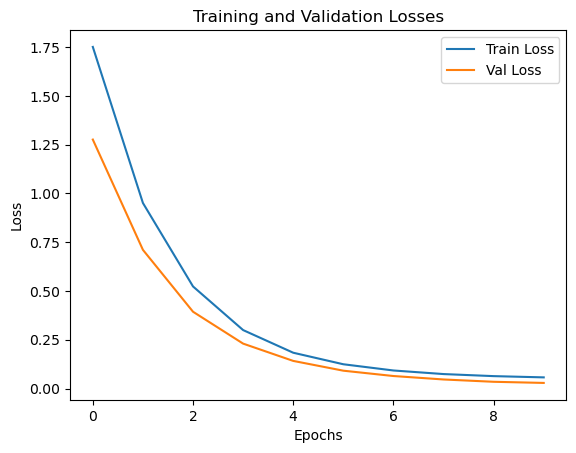

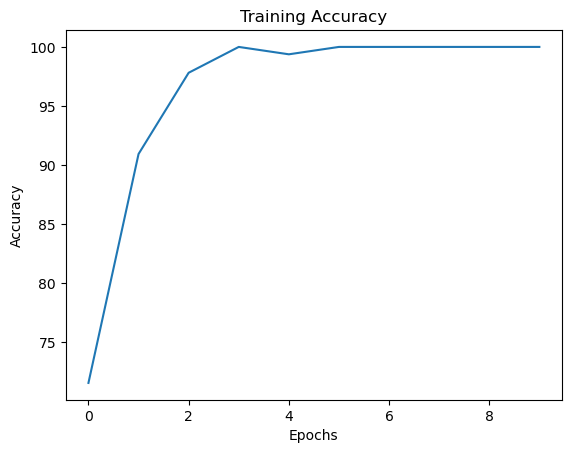

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim.lr_scheduler as lr_scheduler
from PIL import Image
import matplotlib.pyplot as plt
import csv
import random
import numpy as np

class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(16 * 3 * 3, 10)

    def forward(self, x):
        x = F.sigmoid(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.gelu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x



# Define the folder paths and transformations
train_folder_path = "/kaggle/input/spider-ml-inductions-2023-task-1/trainingSet"
test_folder_path = "/kaggle/input/spider-ml-inductions-2023-task-1/test_set"

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Custom transformation function for data augmentation
def modify_image(image, density=0, shift_fraction=0):
    image_np = np.array(image)

    # Apply random pixel modifications
    num_pixels = int(image_np.size * density)
    indices = random.sample(range(image_np.size), num_pixels)
    image_np.flat[indices] /=10

    # Apply random shifts
    width_shift = int(image_np.shape[1] * shift_fraction)
    height_shift = int(image_np.shape[0] * shift_fraction)
    image_np = np.roll(image_np, width_shift, axis=1)
    image_np = np.roll(image_np, height_shift, axis=0)

    # Clip values to valid range
    image_np = np.clip(image_np, 0, 255)

    modified_image = torch.from_numpy(image_np)
    return modified_image

# Custom transformation function for data augmentation
def modify_image_stretch_vertical(image, stretch_pixels=4):
    image_np = np.array(image)

    # Stretch the image vertically by adding extra rows
    image_np = np.concatenate((image_np, np.zeros((stretch_pixels, image_np.shape[1]))), axis=0)

    # Crop the image back to its original size
    image_np = image_np[:image_np.shape[0] - stretch_pixels, :]

    modified_image = torch.from_numpy(image_np)
    return modified_image

def modify_image_stretch_horizontal(image, stretch_pixels=4):
    image_np = np.array(image)

    # Stretch the image horizontally by adding extra columns
    image_np = np.concatenate((image_np, np.zeros((image_np.shape[0], stretch_pixels))), axis=1)

    # Crop the image back to its original size
    image_np = image_np[:, :image_np.shape[1] - stretch_pixels]

    modified_image = torch.from_numpy(image_np)
    return modified_image


# Custom transformation function for 2-pixel layer minimization and rotation
def modify_image_minimize_rotation(image, rotation_angle=15):
    image_np = np.array(image)

    # 2-pixel layer minimization
    minimized_image_np = np.pad(image_np, pad_width=2, mode='constant', constant_values=0)
    minimized_image_pil = Image.fromarray(minimized_image_np)

    # Rotation in one direction
    rotated_image_pil = minimized_image_pil.rotate(rotation_angle)

    # Resize to 28x28
    resized_image_pil = rotated_image_pil.resize((28, 28), Image.AREA)

    modified_image = transforms.ToTensor()(resized_image_pil)
    modified_image = transforms.Normalize((0.5,), (0.5,))(modified_image)
    return modified_image

# Custom transformation function for 2-pixel layer maximization and rotation
def modify_image_maximize_rotation(image, rotation_angle=15):
    image_np = np.array(image)

    # 2-pixel layer maximization
    maximized_image_np = np.pad(image_np, pad_width=2, mode='constant', constant_values=0)
    maximized_image_pil = Image.fromarray(maximized_image_np)

    # Rotation in opposite direction
    rotated_image_pil = maximized_image_pil.rotate(-rotation_angle)

    # Resize to 28x28
    resized_image_pil = rotated_image_pil.resize((28, 28), Image.AREA)

    modified_image = transforms.ToTensor()(resized_image_pil)
    modified_image = transforms.Normalize((0.5,), (0.5,))(modified_image)
    return modified_image

# Update the CustomDataset class to include additional augmentations
class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in range(10):
            subfolder_path = os.path.join(folder_path, str(label))
            image_names = os.listdir(subfolder_path)
            for image_name in image_names:
                self.image_paths.append(os.path.join(subfolder_path, image_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label

# Create the training dataset with data augmentation
original_train_dataset = CustomDataset(train_folder_path, transform)

image_paths = [os.path.join(train_folder_path, str(label), image_name) for label in range(10) for image_name in os.listdir(os.path.join(train_folder_path, str(label)))]
labels = [label for label in range(10) for _ in range(len(os.listdir(os.path.join(train_folder_path, str(label)))))]

# Create additional augmented datasets
vertical_stretch_train_dataset = CustomDataset(train_folder_path, transform)
vertical_stretch_train_dataset.image_paths = image_paths
vertical_stretch_train_dataset.labels = labels
vertical_stretch_train_dataset.transform = transform
vertical_stretch_train_dataset.modify_image = modify_image_stretch_vertical

horizontal_stretch_train_dataset = CustomDataset(train_folder_path, transform)
horizontal_stretch_train_dataset.image_paths = image_paths
horizontal_stretch_train_dataset.labels = labels
horizontal_stretch_train_dataset.transform = transform
horizontal_stretch_train_dataset.modify_image = modify_image_stretch_horizontal


# Create additional augmented datasets for 2-pixel layer minimization and rotation
minimize_rotation_train_dataset = CustomDataset(train_folder_path, transform)
minimize_rotation_train_dataset.image_paths = image_paths
minimize_rotation_train_dataset.labels = labels
minimize_rotation_train_dataset.transform = transform
minimize_rotation_train_dataset.modify_image = modify_image_minimize_rotation

# Create additional augmented datasets for 2-pixel layer maximization and rotation
maximize_rotation_train_dataset = CustomDataset(train_folder_path, transform)
maximize_rotation_train_dataset.image_paths = image_paths
maximize_rotation_train_dataset.labels = labels
maximize_rotation_train_dataset.transform = transform
maximize_rotation_train_dataset.modify_image = modify_image_maximize_rotation

# Merge all the datasets including the new ones
train_dataset = ConcatDataset([
    original_train_dataset,
    vertical_stretch_train_dataset,
    horizontal_stretch_train_dataset,
    minimize_rotation_train_dataset,
    maximize_rotation_train_dataset
])


# Define the split ratio
split_ratio = 0.8
train_size = int(split_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Define the batch size
batch_size =64

# Create the training and validation data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Create the CNN model
model = MyCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Check if multiple GPUs are available
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 10
train_losses = []
val_accuracies = []
val_losses = []

for epoch in range(num_epochs):
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_dataloader:
        # Move data to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Apply weight decay regularization
        l2_lambda = 0.001
        l2_reg = torch.tensor(0., device=device)
        for param in model.parameters():
            l2_reg += torch.norm(param)
        loss += l2_lambda * l2_reg

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    

    # Calculate average loss and accuracy for the epoch
    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)

    # Calculate validation accuracy
    val_total_loss = 0.0  # Initialize validation loss
    val_correct_predictions = 0
    val_total_predictions = 0
    for val_images, val_labels in val_dataloader:
        val_images = val_images.to(device)
        val_labels = val_labels.to(device)

        val_outputs = model(val_images)
        val_loss = criterion(val_outputs, val_labels)
        val_total_loss += val_loss.item()

        _, val_predicted = torch.max(val_outputs, dim=1)
        val_correct_predictions += (val_predicted == val_labels).sum().item()
        val_total_predictions += val_labels.size(0)

    avg_val_loss = val_total_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    val_accuracy = val_correct_predictions / val_total_predictions * 100
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Plotting the training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Plotting the validation accuracy
plt.plot(val_accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()

# Custom Dataset class
class CustomDataset1(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_paths = os.listdir(folder_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.folder_path, self.image_paths[idx])

        # Load the image
        image = Image.open(image_path)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image

# Create the dataset
dataset = CustomDataset1(test_folder_path, transform)

# Create the data loader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Move the model back to CPU if using multiple GPUs
if torch.cuda.device_count() > 1:
    model = model.module

# Perform predictions on test images and save results to CSV
predictions = []

for images in dataloader:
    # Move data to GPU
    images = images.to(device)

    # Forward pass
    outputs = model(images)
    _, predicted = torch.max(outputs, dim=1)
    predictions.extend(predicted.tolist())

# Save predictions to CSV file
csv_file = "submission.csv"

with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["file_name", "pred"])
    image_names = os.listdir(test_folder_path)
    for image_name, prediction in zip(image_names, predictions):
        writer.writerow([image_name, prediction])